In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import matplotlib.patches as patches
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import fisher_exact
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.cm as cm
from pycirclize import Circos
from scipy.interpolate import splprep, splev
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import warnings
from itertools import combinations
import ot
from scipy.spatial.distance import pdist, squareform
from matplotlib.colors import ListedColormap

import surprise as sup

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# Load node attributes

In [2]:
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/transcription_clusters/nodes_{resolution}.parquet"
nodes = pd.read_parquet(fpath)
print(f"{nodes.shape=}")
nodes.head()

nodes.shape=(48681, 17)


,gene_name,gene_biotype,bin_name,chrom,bin,is_pt,is_tf,is_marker,is_core,core_score,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,expression,degree
0,Ulk4,protein_coding,chr9:121,chr9,1394.0,True,False,False,False,0.254849,0.826484,1.149226,1.349552,0.866066,0.573875,4.12,1236
1,Smarca2,protein_coding,chr19:26,chr19,2436.0,True,False,False,False,0.157878,0.497386,0.547185,0.336787,0.839273,0.141617,4.55,609
2,Dlgap3,protein_coding,chr4:127,chr4,665.0,True,False,False,True,0.491722,0.754788,1.027046,1.577616,0.839461,0.906364,87.94,262
3,Gm56531,lncRNA,chr12:8,chr12,1659.0,False,False,False,False,0.310082,0.690311,0.851758,0.774613,0.833768,0.617768,NaN,155
4,Twsg1,protein_coding,chr17:66,chr17,2289.0,True,False,False,False,0.289030,0.767515,0.921479,1.337415,0.571748,0.508463,23.16,140


# Load duplicatation reports

In [3]:
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/duplicate_table/singlecell_mESC_{resolution}_dupes.parquet"
dupes = pd.read_parquet(fpath)
print(f"{dupes.shape=}")

cells = dupes[dupes['unique']]
print(f"(raw) {cells.shape=}")
cells = cells[['read_id', 'cell_id']].drop_duplicates()
print(f"(filtered) {cells.shape=}")
cell_map = dict(zip(cells['read_id'].values, cells['cell_id'].values))

drop_reads = dupes[~dupes['unique']]['read_id'].unique()
print(f"reads to drop: {len(drop_reads)}")

dupes.head()

dupes.shape=(10902736, 8)
(raw) cells.shape=(339359, 8)
(filtered) cells.shape=(339359, 2)
reads to drop: 10563377


,read_id,mapping_quality,cell_id,exactly_unique,approximately_unique,read_group,unique,chrom
280077,00000181-a315-4a91-b680-96ca3b00eef2,30.000000,o1b71,False,False,17,False,chr7
298588,00000450-c609-417b-b21e-262221da074a,45.222222,o1b47,False,False,2,False,chr6
919049,0000075a-0236-46a1-9c08-def49bf4c756,60.000000,o4b67,False,False,515,False,chr6
786323,00000c30-afa4-4cdb-8802-0659c5f6dd1c,54.272727,o3b54,False,False,287,False,chr6
841533,00000c5a-e3a8-4211-bb87-0909050f8b27,43.428571,o1b64,False,False,59,False,chr2


# single-cell transcription factories

In [4]:
""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/singlecell_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
print(f"(raw) {df.shape=}")

""" MERGE and FILTER """
df = pd.merge(
    df, nodes, how="left",
)

df = df[df['gene_biotype'] == 'protein_coding']
df = df[~df['read_name'].isin(drop_reads)].reset_index(drop=True)

df = df.reset_index(drop=True)

""" ADD metadata columns """
df['cell_id'] = df['read_name'].map(cell_map)
df['sample'] = df['cell_id'].str[:2]
df['order'] = df.groupby('read_name')['gene_name'].transform('nunique')

""" FILTER singletons """
df = df[df['order'] > 1].reset_index(drop=True)

print(f"(merged and filtered) {df.shape=}")
print(f"{df.shape=}")
df.head()

(raw) df.shape=(59016150, 4)
(merged and filtered) df.shape=(17784530, 21)
df.shape=(17784530, 21)


,gene_name,gene_biotype,read_name,bin_name,chrom,bin,is_pt,is_tf,is_marker,is_core,...,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,expression,degree,cell_id,sample,order
0,Nmur1,protein_coding,19a335b5-31d1-44a2-ae3e-73433ef3a519,chr1:86,chr1,86.0,True,False,False,True,...,0.803481,1.474600,2.044946,0.442640,4.862435,0.08,149.0,o4b84,o4,3
1,9530068E07Rik,protein_coding,2bfe0dd7-9a79-42ed-b201-c4d10874cb09,chr11:52,chr11,1581.0,True,False,False,True,...,0.707603,0.955214,1.117029,0.830883,1.813519,18.31,36.0,o3b03,o3,3
2,9530068E07Rik,protein_coding,46bcc5b7-3aea-4709-a72d-9e65177e0583,chr11:52,chr11,1581.0,True,False,False,True,...,0.707603,0.955214,1.117029,0.830883,1.813519,18.31,36.0,o3b03,o3,2
3,Zfp354c,protein_coding,3e6dd122-d8f5-562f-86de-fc4e384a667a,chr11:50,chr11,1579.0,True,True,False,True,...,0.793503,1.081546,0.926805,0.995356,1.209588,8.90,65.0,o3b03,o3,3
4,Plcl1,protein_coding,d12f326b-3761-40db-8e89-83fd9a4dc0eb,chr1:55,chr1,55.0,True,False,False,True,...,0.624361,0.674270,0.638057,0.793125,3.164033,0.04,1304.0,NaN,NaN,2


# summarize 

In [5]:
pdf = df.groupby('cell_id').agg(
    hyperedges=('read_name', 'nunique'),
    unique_genes=('gene_name', 'nunique'),
).reset_index()

pdf = pdf.sort_values(by='hyperedges', ascending=False,)
pdf = pdf.reset_index(drop=True)  # Reset the index once
pdf = pdf.reset_index(drop=False)
print(f"{pdf.shape=}")

pdf.head()

pdf.shape=(377, 4)


,index,cell_id,hyperedges,unique_genes
0,0,o3b50,10095,2256
1,1,o4b67,5914,4278
2,2,o3b43,3679,1840
3,3,o3b96,2549,1532
4,4,o1b59,2219,2454


In [6]:
print(pdf['hyperedges'].mean())

491.0026525198939


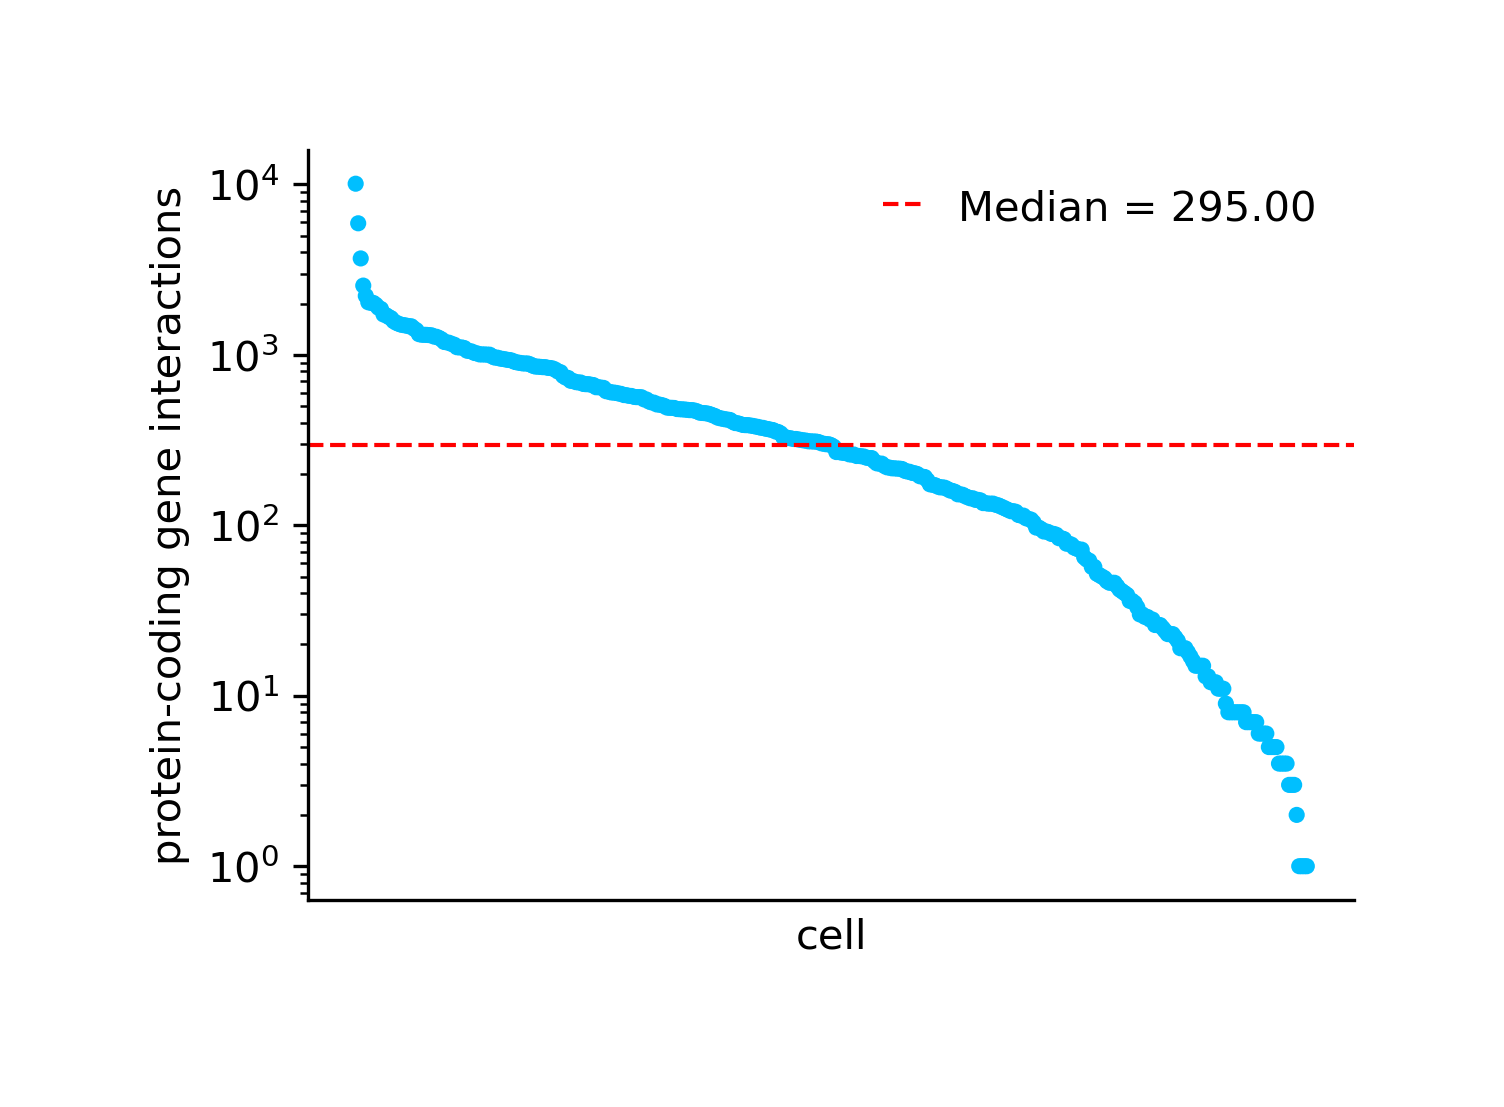

In [7]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 3.25

# Calculate the median y value
median_y = pdf['hyperedges'].median()

# Create the line plot
ax = sns.scatterplot(
    data=pdf,
    x='index',
    y='hyperedges',
    color='deepskyblue',
    ec='none',
    s=15,
)

# Annotate the median line
ax.axhline(
    median_y, 
    color='r',
    linestyle='--',
    linewidth=1,
    label=f'Median = {median_y:.2f}',
)

plt.legend(loc='upper right')

plt.ylabel('protein-coding gene interactions')
plt.xlabel('cell')
plt.xticks([])
plt.yscale('log')

sns.despine()
plt.show()

# Core interactions

In [8]:
tf = 1
d = 2
t = 2.0

"""criteria:
    1. one TF
    2. d protien-coding genes in the core with expression over t
    3. multiple-chromosomes
"""

core = df.copy()
print(f"(raw) {core.shape=}")
core = core[core['expression'].notna()]
core = core[core['is_pt']]
core['is_expressed'] = core['expression'] > t

core = core.groupby(['read_name', 'cell_id']).agg(
    chroms = ('chrom', 'nunique'),
    tf = ('is_tf', 'sum'),
    core = ('is_core', 'sum'),
    expressed = ('is_expressed', 'sum'),
    mean_expression = ('expression', 'mean'),
).reset_index()

print(f"(grouped) {core.shape=}")

core = core[core['tf'] >= tf]
core = core[core['core'] >= d]
core = core[core['expressed'] >= t]

print(f"(filtered) {core.shape=}")

(raw) core.shape=(17784530, 21)
(grouped) core.shape=(185104, 7)
(filtered) core.shape=(6370, 7)


pdf.shape=(312, 3)


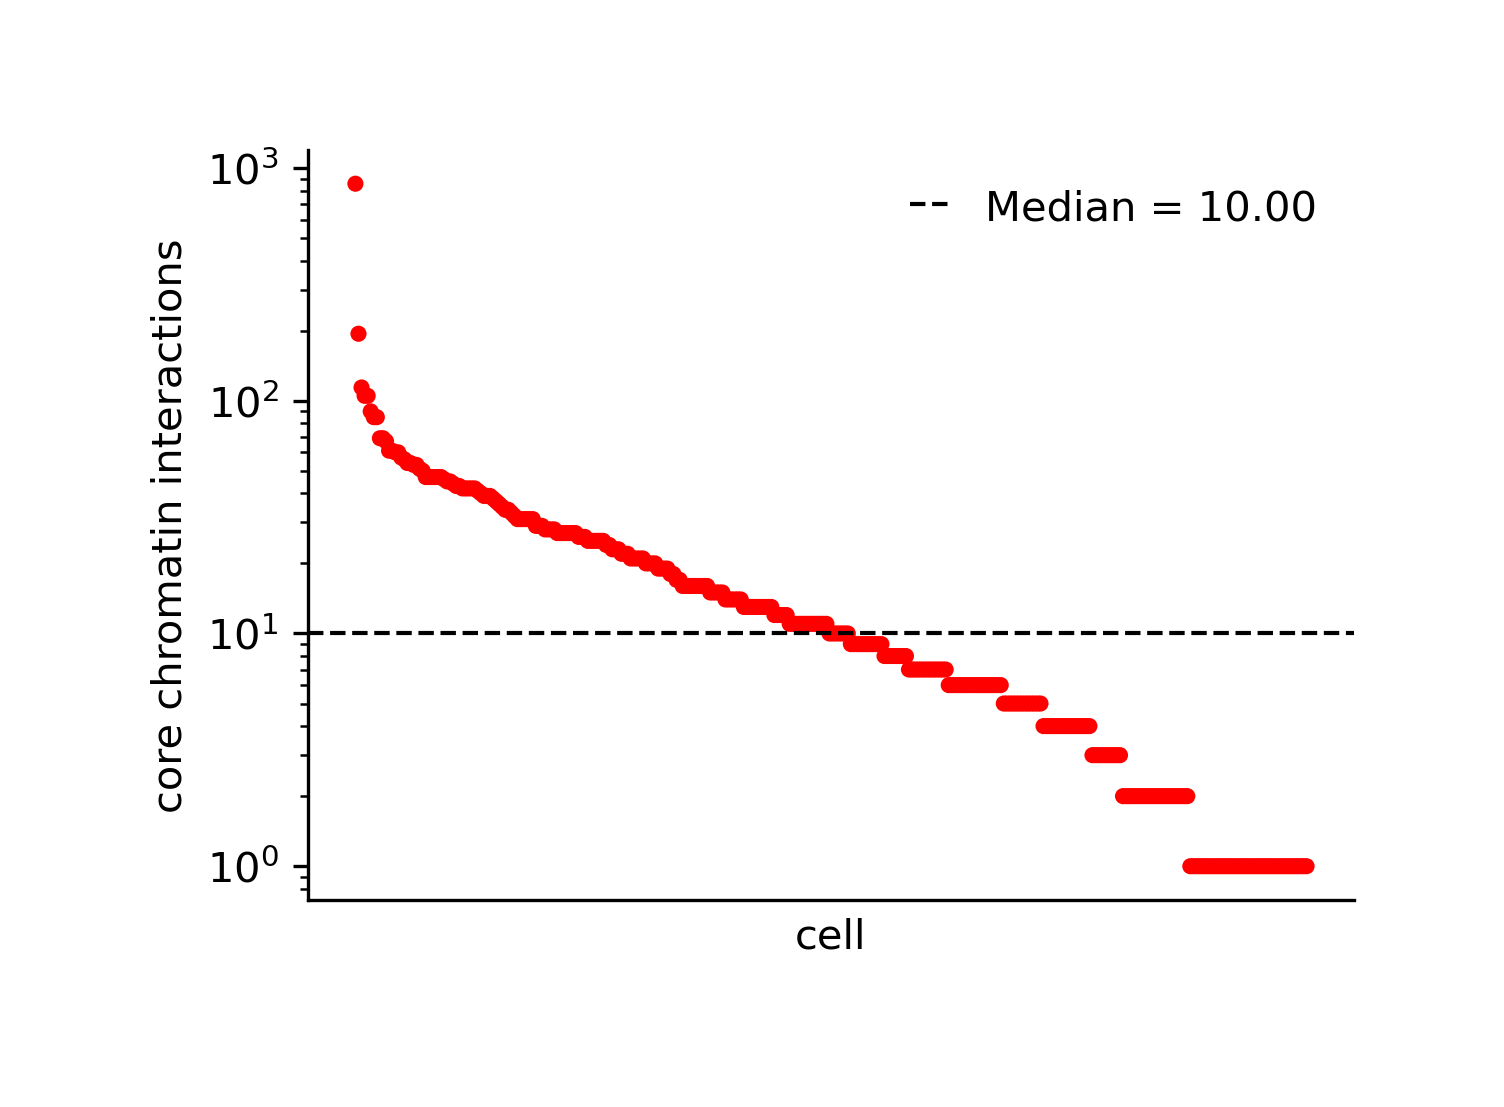

In [9]:
pdf = core.groupby('cell_id').agg(
    hyperedges=('read_name', 'nunique'),
).reset_index()

pdf = pdf.sort_values(by='hyperedges', ascending=False,)
pdf = pdf.reset_index(drop=True)  # Reset the index once
pdf = pdf.reset_index(drop=False)
print(f"{pdf.shape=}")

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4.5, 3.25

# Calculate the median y value
median_y = pdf['hyperedges'].median()

ax = sns.scatterplot(
    data=pdf,
    x='index',
    y='hyperedges',
    color='red',
    ec='none',
    s=15,
)

# Annotate the median line
ax.axhline(
    median_y, 
    color='k',
    linestyle='--',
    linewidth=1,
    label=f'Median = {median_y:.2f}',
)

plt.legend(loc='upper right')

plt.ylabel('core chromatin interactions')
plt.xlabel('cell')
plt.xticks([])
plt.yscale('log')

sns.despine()
plt.show()

# save the single-cell incidence

In [10]:
def make_incidence(df):
    df['value'] = 1
    df['read_index'] = df['read_name'].astype('category').cat.codes
    df['gene_index'] = df['gene_name'].astype('category').cat.codes
    
    data = df['value'].tolist()
    row = df['gene_index'].values
    col = df['read_index'].values
    
    n = df['gene_index'].nunique()
    m = df['read_index'].nunique()
    
    index = df['gene_name'].unique()
    columns = df['read_name'].unique()
    
    X = csr_matrix((data, (row, col)), shape=(n, m))
    X = csr_matrix((X > 0).astype(int))
    H = pd.DataFrame.sparse.from_spmatrix(
        X, index=index, columns=columns,
    )
    del X
    del data
    del row
    del col
    del index
    del columns
    return H

# Store the core

In [11]:
H = df[df['read_name'].isin(core['read_name'].values)].copy()
print(f"{H.shape=}")
H['read_name'] = H['cell_id'] + ":" + H['read_name']

"""  STRUCTURE the incidence matrix """
H = make_incidence(H)
print(f"{H.shape=}")
print(f"{type(H)=}")
print(f"DataFrame size: {H.memory_usage().sum() / 1024**2:.2f} MB")

outpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/transcription_clusters/singlecell_core_incidence_{resolution}_protien_coding_only.pkl"
H.to_pickle(outpath)
H.head()

H.shape=(29053, 21)
H.shape=(4420, 6370)
type(H)=<class 'pandas.core.frame.DataFrame'>
DataFrame size: 0.37 MB


,o3b03:3e6dd122-d8f5-562f-86de-fc4e384a667a,o3b96:1c1ffd57-ddd5-46cd-9c32-1dfa892c18be,o3b96:0759fe0f-df87-42e6-96c9-698671d5a7e2,o3b96:375781eb-927e-45ee-9155-ab4052b430bb,o1b59:ec5db31e-c0ae-44c5-91e0-bc40f486a37f,o3b50:c4af0102-ded4-4b11-bbf8-cbfdc1c1ae29_1,o3b50:b2098de7-780c-5e25-aef7-fc2fd55a730d_1,o3b03:6efe764e-ad6c-419b-8173-5a2e393b975d,o3b50:7faebcef-ab2e-43ed-accf-6bc9acd1655a_1,o3b50:d216bf99-0efd-4cb9-8908-6b97fafb3710,...,o3b31:00bd62b4-fdcf-4933-81bc-9a7b2dc280ca,o1b54:9b7f1801-2d0a-4d8e-8dff-3331cc9ae865_2,o4b27:78e6b31b-535d-4369-9369-b35b2f0d2c14,o1b31:4088b82d-702d-464f-8b9f-6f8adc4a312d,o4b46:533deccf-b0e3-4ccf-9339-12ca025a5b62,o1b22:a992959f-ead4-4dd6-853a-8c4fb93bc864,o1b44:38e3c9e2-b4c9-5b67-99c4-4f998703f861_1,o3b71:94739dfb-5f52-4d4b-9195-41ecf186ed0f,o3b26:066b320c-18bc-4efa-8ecc-0f18e1cf010a,o1b05:628d946e-d517-4b88-830b-f25c1d38d1a1
Zfp354c,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Coro2b,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Grk5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Alpk3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Slc10a7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
